# Convolutional Variational Autoencoders using MNIST 

For this notebook we are using a **Convolutional Variational Autoencoder** trained on MNIST dataset and we will use this architecture to generate new images

This generative model combines the strengths of convolutional neural networks and variational autoencoders making it specifically good for image related tasks.

The key working principles of Convolutional Variational Autoencoders are as follows:

***Convolutional Layers***: We leverage convolutional layers to efficiently capture spatial hierarchies and local patterns within images which enables the model to recognize features at different scales, providing a robust representation of the input data.

***Variational Inference***: The introduction of variational inference allows the model to capture uncertainty in the latent space to generate a probability distribution rather than producing a single deterministic latent representation

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

## Parameters

In [2]:
# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2 #For grayscale MNIST images

**Latent Dimension**

The latent dimension is the size of the vector that represents the compressed version of the input data in the VAE. The latent dimension affects how much information the VAE can encode and decode, and how diverse the generated outputs can be. 

* A larger latent dimension can capture more details and variations, but it can also lead to instability

* A smaller latent dimension can force the VAE to learn more efficient representations, but it can also limit the expressiveness and quality of the outputs

To choose the optimal latent dimension can be selected through experimentation with different values and comparing the reconstruction and generation performance of the VAE.

## Data Preparation 

In [3]:
def map_image(image, label):
    """Returns a normalized and reshaped tensor from a given image
       Used for unsupervised learning in the autoencoder"""
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape=(28, 28, 1,))
    return image


def get_dataset(map_fn, is_validation=False):
    """Loads and prepares the mnist dataset from TFDS and shuffle the data"""
    if is_validation:
        split_name = "test"
    else:
        split_name = "train"

    dataset = tfds.load('mnist', as_supervised=True, split=split_name)
    dataset = dataset.map(map_fn)
  
    if is_validation:
        dataset = dataset.batch(BATCH_SIZE)
    else:
        dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

    return dataset

Download the dataset

In [4]:
train_dataset = get_dataset(map_image)

## Build the Model

Lets build our VAE model

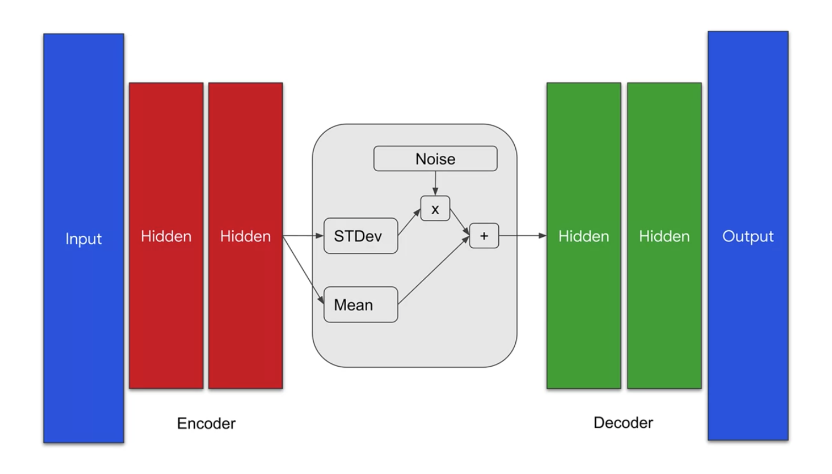

The image above shows the encoder-decoder architecture of the VAE with the main difference being the grey box in the middle that shows the sampling layer. In this layer, the model mixes a random sample and combines it with the outputs of the encoder. This mechanism makes it useful for generating new content. 

Let's build these parts in the sections

### Sampling Class

We will build the `Sampling` class which is also the bottleneck of the network. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample


In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """Generates a random sample and combines with the encoder output
           Args:
           inputs -- output tensor from the encoder

           Returns:
           noisy_ip -- input tensors combined with a random sample"""

        # unpack the output of the encoder
        mu, sigma = inputs

        # get the size and dimensions of the batch
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # generate a random tensor the given shape filled with values of the dtype type from a normal distribution
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # combine the inputs and noise
        noisy_ip= mu + tf.exp(0.5 * sigma) * epsilon
        return noisy_ip

### Encoder

To build the encoder, we will follow the architecture shown below,

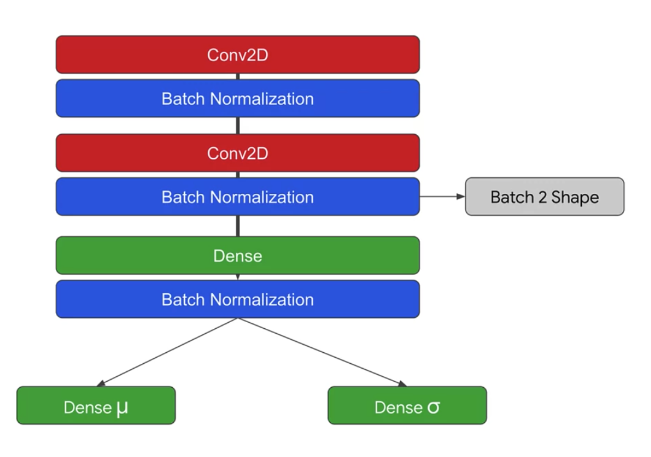


Aside from mu and sigma, we you will also output the shape of features before flattening it. This will be useful when reconstructing the image later in the decoder.

In [6]:
def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space

    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_2.shape -- shape of the features before flattening"""

    # Two Conv2D layers followed by BatchNormalization
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

    # Second batch norm : one of the outputs of the encoder layer
    batch_2 = tf.keras.layers.BatchNormalization()(x)

    # flatten the features and feed into the Dense network
    # Number of units in the dense network is defined on experimentation, we set it at 20
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)
    x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

    return mu, sigma, batch_2.shape

### Putting it together

Let us define the encoder model function and call the sampling class

In [7]:
def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening"""

    # declare the inputs tensor using input shape information
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get the output of the encoder_layers() function 
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # build the whole encoder model
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

    return model, conv_shape

### Decoder

We will build the decoder part of the network which expands the latent representations back to the original image dimensions.

For decoder, we've used

* A dense layer wuth batch normalization

* Reshaping it back to the shape of the output at the encoder side before flattening

* 2 Conv2DTranspose with batch normalization

* A single conv2DTranspose operation with 1 filter to bring it back to the same shape as the i/p (28*28*1)

In [8]:
def decoder_layers(inputs, conv_shape):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder 
      conv_shape -- shape of the features before flattening

    Returns:
      x -- tensor containing the decoded output"""

    # feed to a Dense network with units computed from the conv_shape dimensions
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
  
    # reshape output using the conv_shape dimensions
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

    # upsample the features back to the original dimensions
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x) 
    return x

Lets define the decoder model now

In [9]:
def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening

    Returns:
      model -- the decoder model"""

    # set the inputs to the shape of the latent space
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # get the output of the decoder layers
    outputs = decoder_layers(inputs, conv_shape)

    # declare the inputs and outputs of the model
    model = tf.keras.Model(inputs, outputs)
  
    return model

### Kullback–Leibler Divergence

Here we define the KL loss. We will include the reconstruction loss in the training loop

In [10]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation

    Returns:
      kl_loss -- KLD loss"""
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5
    return kl_loss

### VAE Model

Here we can define the entire VAE model.

Note:

* We are using *model.add_loss()* to add the KL and reconstruction loss

* Loss computation doesn't use *y_true* and *y_pred* so it can't be used in *model.compile()*

* Reconstruction loss will be added in the training loop

In [11]:
def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch

    Returns:
      model -- the complete VAE model"""

    # set the inputs
    inputs = tf.keras.layers.Input(shape=input_shape)
    # get mu, sigma, and z from the encoder output
    mu, sigma, z = encoder(inputs)  
    # get reconstructed output from the decoder
    reconstructed = decoder(z)
    # define the inputs and outputs of the VAE
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    # add the KL loss
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)
    return model
     


We'll add a helper function to setup and get the different models from the functions we have defined earlier

In [12]:
def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models separately"""
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae

In [13]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

In [14]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encode_conv2 (Conv2D)          (None, 7, 7, 64)     18496       ['batch_normalization[0][0]']

In [15]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 decode_dense1 (Dense)       (None, 3136)              9408      
                                                                 
 batch_normalization_3 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 decode_reshape (Reshape)    (None, 7, 7, 64)          0         
                                                                 
 decode_conv2d_2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256 

## Train the Model

In this section we will train the model.

We will start by defining the reconstruction loss, optimizer and metric.

In [16]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

**Visualization functions**

The function below will help us visualize the progress of image generation at each epoch. We will be seeing images as 4x4 grids

In [17]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images
    Args:

    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (16, LATENT_DIM) """

    # generate images from the test input
    predictions = model.predict(test_input)

    # plot the results
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
          plt.subplot(4, 4, i+1)
          plt.imshow(predictions[i, :, :, 0], cmap='gray')
          plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    # plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

**Training Loop**

The training loop is shown below. We will run the training for 10 epochs for now and display the generated images at each epoch. 

As mentioned earlier, we will add the KLD loss to the binary crossentropy loss before we get the gradients and update the weights.

As the network learns and we will see images that resemble the MNIST dataset

1/1 [==============================] - 0s 22ms/step


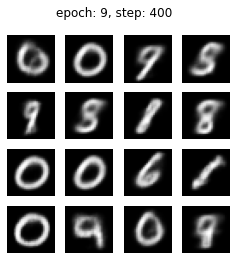

Epoch: 9 step: 400 mean loss = 158.84856


In [18]:
# Training loop. 

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 10

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            # feed a batch to the VAE model
            reconstructed = vae(x_batch_train)

            # compute reconstruction loss
            flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784 #784 for dimensions of the image
      
            # add KLD regularization loss to reconstruction loss
            loss += sum(vae.losses)  

        # get the gradients and update the weights
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # compute the loss metric
        loss_metric(loss)

        # display outputs every 100 steps
        if step % 100 == 0:
            display.clear_output(wait=False)    
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))